<a href="https://colab.research.google.com/github/LuLu1-1/General-data-analysis/blob/main/supply_chain_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/supply_chain_data/SupplyChain.csv', encoding='unicode_escape')

# Data cleaning and transform

In [ ]:
# delete row with multi null value
df.drop(index=130590,inplace=True)
# create new feature: shippment_late_days
df['shippment_late_days'] = df['Days for shipment (scheduled)'] - df['Days for shipping (real)']
df['isfraud'] = (df['Order Status']=='SUSPECTED_FRAUD').astype('int')
df['isloss'] = (df['Benefit per order']<0).astype('int')
# drop columns with repeated values
df.drop(['Customer Email','Customer Password','Order Profit Per Order','Order Zipcode','Product Description','Product Category Id','Product Image','Product Card Id','Product Price','Order Item Total'],axis=1,inplace=True)

In [ ]:
# transform date time
shiptimeTemp = pd.DatetimeIndex(df['shipping date (DateOrders)'])
df['ship_year'] = shiptimeTemp.year
df['ship_month'] = shiptimeTemp.month
df['ship_week_day'] = shiptimeTemp.weekday
df['ship_hour'] = shiptimeTemp.hour

timeTemp = pd.DatetimeIndex(df['order date (DateOrders)'])
df['order_year'] = timeTemp.year
df['order_month'] = timeTemp.month
df['order_week_day'] = timeTemp.weekday
df['order_hour'] = timeTemp.hour

df['ship_after_order'] = (shiptimeTemp - timeTemp).days

In [ ]:
# fill minority null value with median 
df['Customer Zipcode'].fillna(df['Customer Zipcode'].mode()[0],inplace=True)
# transform data type to save memory
int8type = ['Days for shipping (real)','Order Item Quantity','Days for shipment (scheduled)','Late_delivery_risk','Department Id']
int32type = ['Category Id','Customer Id','Order Id','Order Item Id','Customer Zipcode','Order Item Cardprod Id']
float16type = ['Order Item Discount Rate','Order Item Profit Ratio']
df[int8type] = df[int8type].astype('int8')
df[int32type] = df[int32type].astype('int32')
df[float16type] = df[float16type].astype('float16')

# Overal sales and profit analysis

In [ ]:
df[df['Order Item Quantity']>1].head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Order Status,Product Name,Product Status,shipping date (DateOrders),Shipping Mode,shippment_late_days,isfraud,isloss,ship_year,ship_month,ship_week_day,ship_hour,order_year,order_month,order_week_day,order_hour,ship_after_order
48,PAYMENT,5,2,-30.750000,115.18,Late delivery,1,17,Cleats,Bayamon,Puerto Rico,XXXXXXXXX,Mary,9083,Frank,XXXXXXXXX,Home Office,PR,75 Sunny Grounds,957,4,Apparel,18.380119,-66.183128,Pacific Asia,Mirzapur,India,2/24/2016 13:57,28744,365,4.8,0.040009,71956,59.990002,-0.270020,2,119.980003,South Asia,Uttar Pradesh,PENDING_PAYMENT,Perfect Fitness Perfect Rip Deck,0.0,2/29/2016 13:57,Second Class,-3,0,1,2016,2,0,13,2016,2,2,13,5
49,PAYMENT,2,2,-122.730003,79.18,Shipping on time,0,29,Shop By Sport,Caguas,Puerto Rico,XXXXXXXXX,Mary,4741,Smith,XXXXXXXXX,Home Office,PR,9731 Honey Fox Towers,725,5,Golf,18.235573,-66.370613,Pacific Asia,Bursa,Turquía,10/25/2016 14:39,45461,627,0.8,0.010002,113598,39.990002,-1.549805,2,79.980003,West Asia,Bursa,PENDING_PAYMENT,Under Armour Girls' Toddler Spine Surge Runni,0.0,10/27/2016 14:39,Second Class,0,0,1,2016,10,3,14,2016,10,1,14,2


In [ ]:
# null values ratio
df[df.columns[df.isnull().sum()/df.shape[0]>0]].isnull().sum()/df.shape[0]

Customer Lname    0.000046
dtype: float64

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

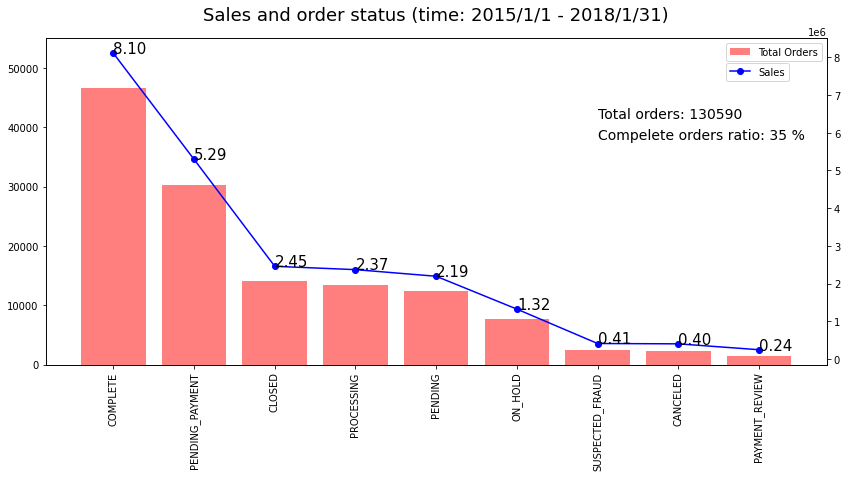

In [ ]:
temp = pd.concat([df.groupby('Order Status')['Sales per customer'].sum(),df['Order Status'].value_counts()],axis=1).sort_values(by='Order Status',ascending=False)
x = plt.figure(figsize=(14,6))
a = x.add_subplot(111) 
a.bar(temp.index,temp['Order Status'],color='red',alpha=0.5,label='Total Orders')
a.legend()
plt.text(6,41600,'Total orders: '+str(df.shape[0]),fontsize=14)
plt.text(6,38000,'Compelete orders ratio: '+str(df[df['Order Status']=='COMPLETE']['Sales per customer'].sum()/df['Sales per customer'].sum()*100)[:2]+' %',fontsize=14)
plt.xticks(rotation=90)
plt.ylim((0,55000))

b = a.twinx()   
b.plot(temp.index,temp['Sales per customer'],color='b',marker='o',label='Sales')
b.legend(bbox_to_anchor = (0.958,0.94))
for i,j in zip(temp.index,temp['Sales per customer']):
    plt.text(i,j,str(j*10e-7)[:4],fontsize=15)
plt.title('Sales and order status (time: 2015/1/1 - 2018/1/31)',fontsize=18,pad=18)
plt.show()

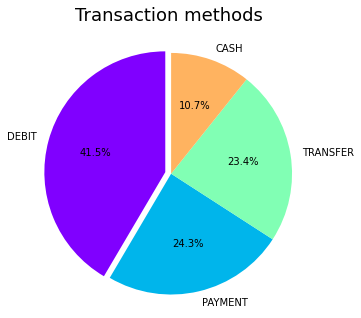

In [ ]:
from  matplotlib import cm
temp = df['Type'].value_counts()
plt.figure(figsize = (5,5))
plt.pie(temp.values, explode=[0.05, 0, 0,0], colors=cm.rainbow(np.arange(len(temp.values))/len(temp.values)),labels=temp.index, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")   
plt.title('Transaction methods',fontsize=18,pad=18) 
plt.show()

In [ ]:
# effective orders definition: 'Order Status' == 'COMPLETE'
comp = df[df['Order Status']=='COMPLETE']
# loss orders : benefit per order < 0
loss = comp[comp['isloss']==1]
# late delivery: 
late = comp[comp['Late_delivery_risk']==1]
# fraud orders : 'Order Status' == 'SUSPECTED_FRAUD', complete orders and frauds are independent
fraud = df[df['isfraud']==1]

In [ ]:
comp.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Product Status,shippment_late_days,isfraud,isloss,ship_year,ship_month,ship_week_day,ship_hour,order_year,order_month,order_week_day,order_hour,ship_after_order
count,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.0,46608.000000,46608.0,46608.000000,46608.00000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000,46608.000000
mean,3.529180,2.946833,21.408394,173.930612,0.573807,31.075760,6734.474575,38765.109895,5.346593,30.549123,-86.382699,36918.048082,673.969211,19.845667,0.102478,91967.461852,130.894987,0.121643,2.132166,193.776053,0.0,-0.582346,0.0,0.184003,2016.00191,6.316383,3.005814,11.576596,2015.992877,6.303446,3.001566,11.539521,3.505814
std,1.605759,1.350056,100.052960,118.728990,0.494528,15.833029,4225.329861,37656.148960,1.639417,9.646821,21.879679,21448.203222,338.595373,21.412855,0.070618,53085.839993,133.515173,0.467285,1.452104,131.179311,0.0,1.497210,0.0,0.387491,0.83968,3.393164,2.009522,6.915452,0.836387,3.396377,2.007800,6.928335,1.649082
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025986,5.000000,19.000000,0.000000,0.000000,9.000000,9.990000,-2.750000,1.000000,9.990000,0.0,-4.000000,0.0,0.000000,2015.00000,1.000000,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,6.830000,101.980003,0.000000,18.000000,3250.000000,725.000000,4.000000,18.275816,-104.875382,18056.000000,403.000000,5.200000,0.040009,45129.750000,50.000000,0.080017,1.000000,119.980003,0.0,-1.000000,0.0,0.000000,2015.00000,3.000000,1.000000,6.000000,2015.000000,3.000000,1.000000,5.000000,2.000000
50%,3.000000,4.000000,30.480000,156.759995,1.000000,26.000000,6500.000000,27606.000000,5.000000,33.782452,-80.172943,37655.000000,564.000000,13.560000,0.099976,93984.500000,59.990002,0.270020,1.000000,179.970001,0.0,-1.000000,0.0,0.000000,2016.00000,6.000000,3.000000,12.000000,2016.000000,6.000000,3.000000,12.000000,3.000000
75%,5.000000,4.000000,61.770000,227.960007,1.000000,45.000000,9843.000000,79927.000000,7.000000,39.653530,-66.370598,55220.250000,1004.000000,28.000000,0.160034,138111.250000,199.990005,0.360107,3.000000,250.000000,0.0,0.000000,0.0,0.000000,2017.00000,9.000000,5.000000,18.000000,2017.000000,9.000000,5.000000,18.000000,5.000000
max,6.000000,4.000000,864.000000,1899.989990,1.000000,76.000000,20755.000000,99205.000000,12.000000,48.781933,115.263077,77202.000000,1363.000000,500.000000,0.250000,180517.000000,1999.989990,0.500000,5.000000,1999.989990,0.0,2.000000,0.0,1.000000,2018.00000,12.000000,6.000000,23.000000,2018.000000,12.000000,6.000000,23.000000,6.000000


In [ ]:
comp.describe(include='O')

,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Region,Order State,Order Status,Product Name,shipping date (DateOrders),Shipping Mode
count,46608,46608,46608,46608,46608,46608,46608,46606,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608,46608
unique,1,3,50,562,2,1,726,1078,1,3,46,6220,11,5,2929,151,19141,23,964,1,118,18954,4
top,DEBIT,Late delivery,Cleats,Caguas,EE. UU.,XXXXXXXXX,Mary,Smith,XXXXXXXXX,Consumer,PR,4174 Pleasant Mountain Acres,Fan Shop,Europe,New York City,Estados Unidos,10/20/2015 4:08,Central America,Inglaterra,COMPLETE,Perfect Fitness Perfect Rip Deck,8/1/2015 18:37,Standard Class
freq,46608,26744,6641,15076,30895,46608,17074,16457,46608,26078,15713,41,15168,13532,600,6390,5,7445,1752,46608,6628,10,27703


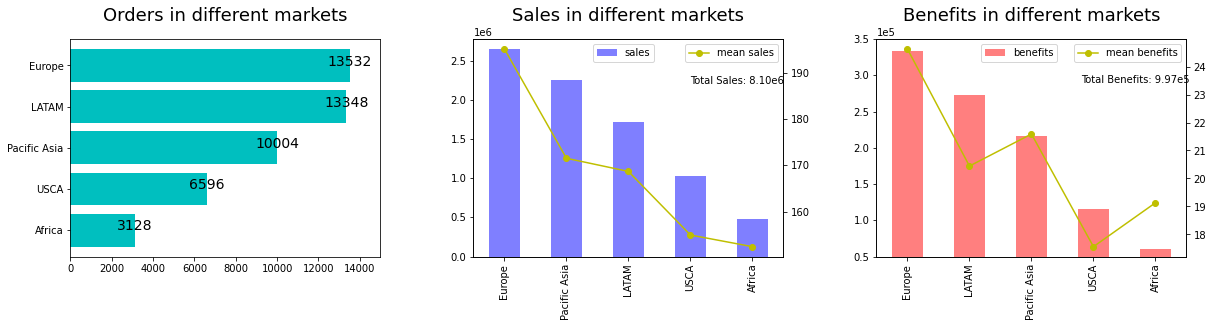

In [ ]:
plt.figure(figsize=(20,4))
c=plt.subplot(131)
plt.barh(comp['Market'].value_counts().sort_values(ascending=True).index,comp['Market'].value_counts().sort_values(ascending=True).values,color='c')
plt.xlim([0,15000])
for x,y in zip(comp['Market'].value_counts().sort_values(ascending=True).values,comp['Market'].value_counts().sort_values(ascending=True).index):
    plt.text(x,y,str(x),fontsize=14,horizontalalignment='center')
plt.title('Orders in different markets',fontsize=18,pad=18)

a=plt.subplot(132)
comp.groupby('Market')['Sales per customer'].sum().sort_values(ascending=False).plot.bar(color='b',alpha=0.5,label='sales')
plt.xlabel('')
plt.title('Sales in different markets',fontsize=18,pad=18)
plt.text(3,2200000,'Total Sales: '+str(comp['Sales per customer'].sum()*10e-7)[:4]+'e6',fontsize=10)
plt.legend(bbox_to_anchor = (0.6,1))
a2=a.twinx()
a2.plot(comp.groupby('Market')['Sales per customer'].mean().sort_values(ascending=False),color='y',marker='o',label='mean sales')
plt.legend()

b=plt.subplot(133)
comp.groupby('Market')['Benefit per order'].sum().sort_values(ascending=False).plot.bar(color='r',alpha=0.5,label='benefits')
plt.xlabel('')
plt.ylim(50000,350000)
plt.title('Benefits in different markets',fontsize=18,pad=18)
plt.text(2.8,290000,'Total Benefits: '+str(comp['Benefit per order'].sum()*10e-6)[:4]+'e5',fontsize=10)
plt.legend(bbox_to_anchor = (0.6,1))
b.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

temp = comp.groupby('Market')['Benefit per order'].mean().sort_values(ascending=False).to_frame().reindex(['Europe','LATAM','Pacific Asia','USCA','Africa'])

b2=b.twinx()
b2.plot(temp,color='y',marker='o',label='mean benefits')
plt.legend()
plt.subplots_adjust(wspace =0.3, hspace =0)

In [ ]:
comp['Type'].value_counts()

DEBIT    46608
Name: Type, dtype: int64

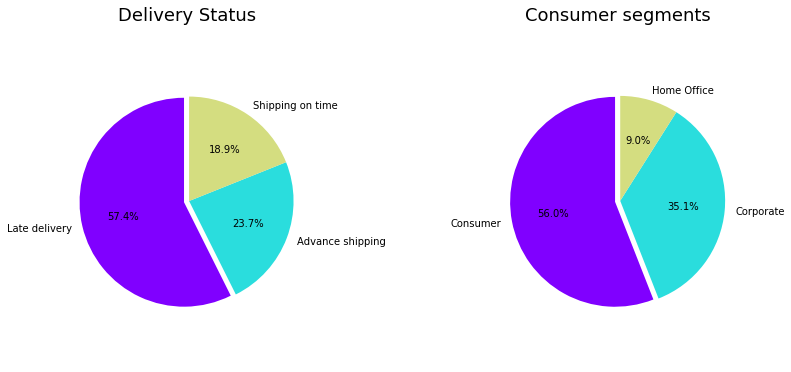

In [ ]:
plt.figure(figsize=(12,6))
a = plt.subplot(121)
temp = comp['Delivery Status'].value_counts()
a.pie(temp.values, explode=[0.05, 0, 0], colors=cm.rainbow(np.arange(len(temp.values))/len(temp.values)),labels=temp.index, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")   
plt.title('Delivery Status',fontsize=18,pad=18) 
b = plt.subplot(122)
temp = comp['Customer Segment'].value_counts()
b.pie(temp.values, explode=[0.05, 0, 0], colors=cm.rainbow(np.arange(len(temp.values))/len(temp.values)),labels=temp.index, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")   
plt.title('Consumer segments',fontsize=18,pad=18) 
plt.subplots_adjust(wspace =0.8, hspace =0)

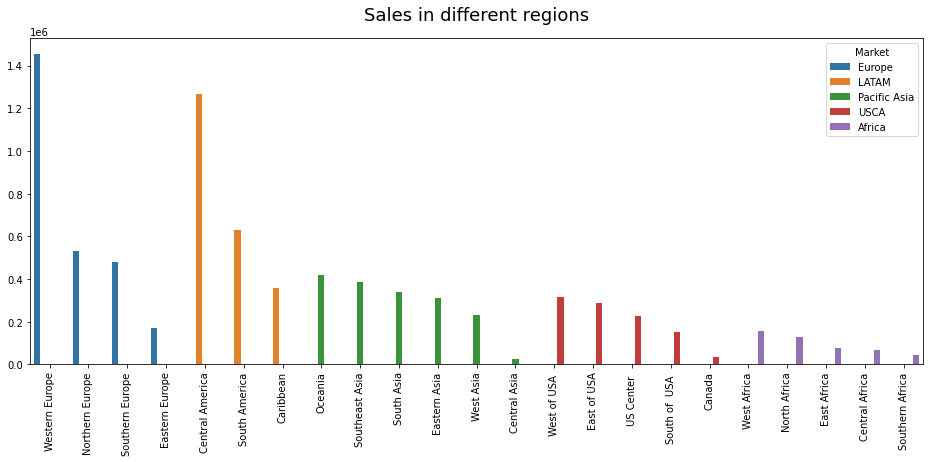

In [ ]:
sr = comp.groupby(['Market','Order Region'])['Sales per customer'].sum().reset_index().sort_values(['Market','Sales per customer'], ascending = [True,False]).reset_index(drop=True)
sr = sr.append(temp[:5]).reset_index(drop=True).drop(temp.index[:5]).reset_index(drop=True)
plt.figure(figsize=(16, 6))
sns.barplot(x="Order Region",y="Sales per customer",data=sr,hue="Market")
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title('Sales in different regions',fontsize=18,pad=18)
plt.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

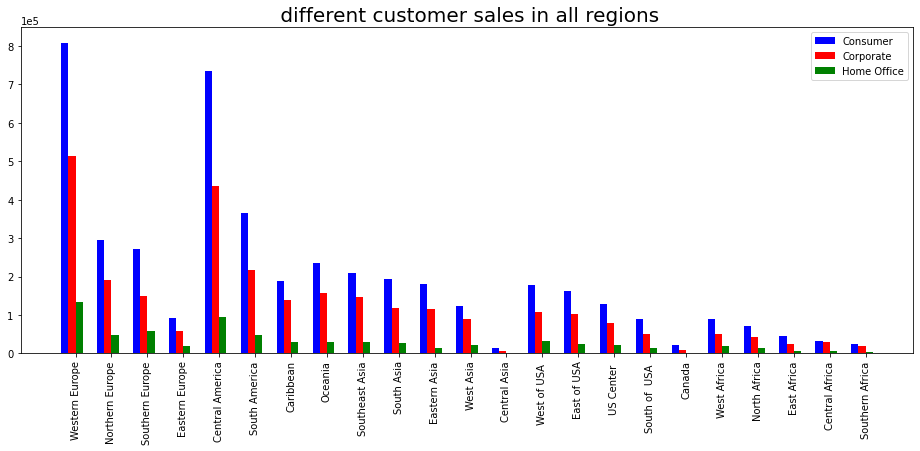

In [ ]:
region_num = comp['Order Region'].nunique()
index = np.arange(region_num)
bar_width = 0.2
region_custm_sale = comp[['Order Region','Customer Segment','Sales per customer']].groupby(['Customer Segment','Order Region'])['Sales per customer'].sum()
fig,ax = plt.subplots(figsize=(16,6))
custm1 = plt.bar(index, region_custm_sale['Consumer'].reindex(sr['Order Region'].values), bar_width, color='b', label='Consumer')
custm2 = plt.bar(index+bar_width, region_custm_sale['Corporate'].reindex(sr['Order Region'].values), bar_width, color='r', label='Corporate')
custm3 = plt.bar(index+bar_width*2, region_custm_sale['Home Office'].reindex(sr['Order Region'].values), bar_width, color='g', label='Home Office')

plt.title(' different customer sales in all regions',fontsize=20)
plt.legend()
plt.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
names = sr['Order Region'].values
plt.xticks(index+bar_width*1.5, names, rotation='vertical')
plt.show()

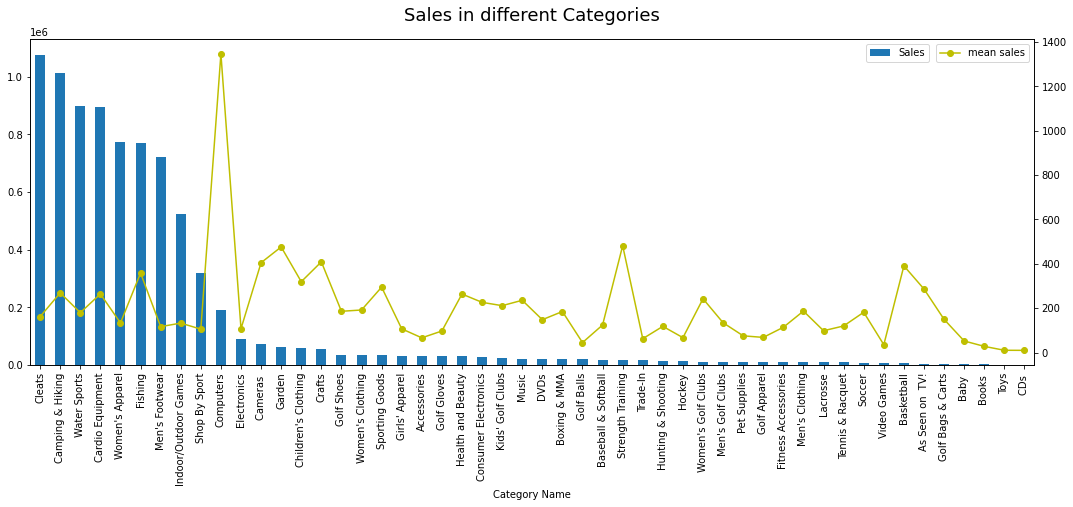

In [ ]:
TsalesByCatename = comp.groupby('Category Name')['Sales per customer'].sum().sort_values(ascending=False)
a = TsalesByCatename.plot.bar(figsize=(18,6),label='Sales')
plt.title('Sales in different Categories',fontsize=18,pad=18)
plt.legend(bbox_to_anchor = (0.9,1))
b = a.twinx()
MsalesByCatename = comp.groupby('Category Name')['Sales per customer'].mean().reindex(TsalesByCatename.index)
b.plot(MsalesByCatename,color='y',marker='o',label='mean sales')
plt.legend()

In [ ]:
sc = comp.groupby(['Market','Category Name'])['Sales per customer'].sum()
markets = comp['Market'].value_counts().index

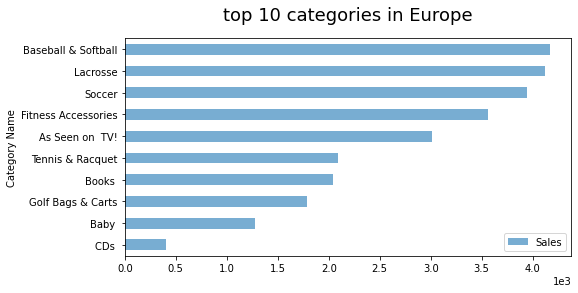

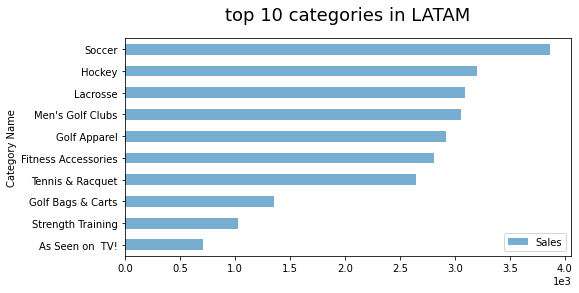

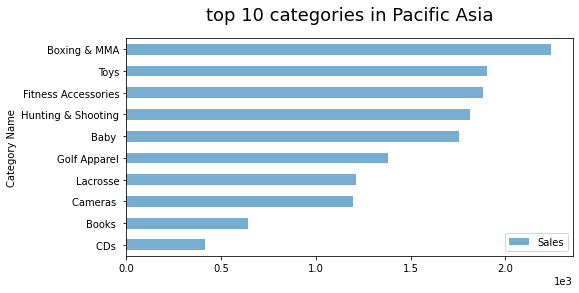

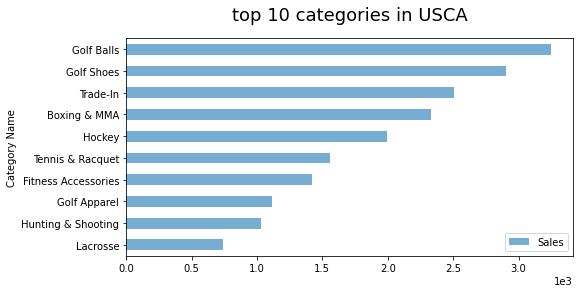

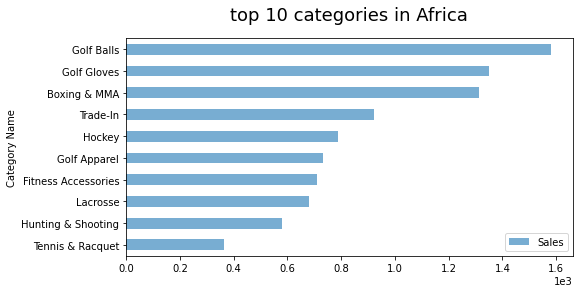

<Figure size 432x288 with 0 Axes>

In [ ]:
for n in markets:
  sc[n].sort_values(ascending=True)[:10].plot.barh(figsize=(8,4),alpha=0.6,label='Sales')
  plt.xlabel('')
  plt.title('top 10 categories in '+n,fontsize=18,pad=18)
  plt.legend()
  plt.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
  plt.show()
  plt.clf()

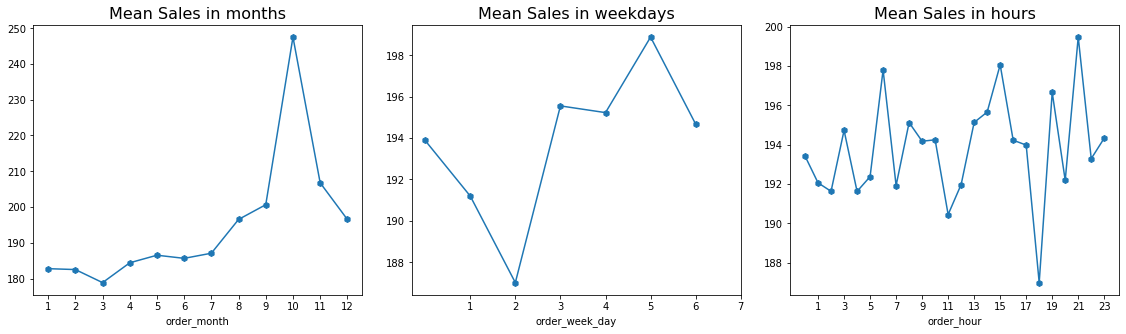

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
salesByMonth = comp.groupby('order_month')['Sales per customer'].mean()
salesByMonth.plot(marker='h')
plt.xticks(np.arange(1,13,1))
plt.title('Mean Sales in months',fontsize=16)

plt.subplot(132)
salesByWeekday = comp.groupby('order_week_day')['Sales per customer'].mean()
salesByWeekday.plot(marker='h')
plt.xticks(np.arange(1,8,1))
plt.title('Mean Sales in weekdays',fontsize=16)

plt.subplot(133)
salesByHour = comp.groupby('order_hour')['Sales per customer'].mean()
salesByHour.plot(marker='h')
plt.xticks(np.arange(1,25,2))
plt.title('Mean Sales in hours',fontsize=16)

plt.tight_layout(pad=2.0)

# Loss benefits analysis

In [ ]:
loss.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Product Status,shippment_late_days,isfraud,isloss,ship_year,ship_month,ship_week_day,ship_hour,order_year,order_month,order_week_day,order_hour,ship_after_order
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.0,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,3.557603,2.966068,-108.987563,171.650464,0.580224,31.063433,6668.689715,37673.980644,5.353428,30.503171,-85.933114,37003.699510,673.968050,19.674348,0.103455,92195.953825,128.850464,-0.632812,2.133279,191.324607,0.0,-0.591535,0.0,1.0,2016.004431,6.327425,2.991488,11.513526,2015.996035,6.309235,3.021222,11.484142,3.535564
std,1.596189,1.341299,155.743106,113.501193,0.493551,15.724848,4206.576343,37446.763447,1.640442,9.779800,21.455924,21241.087599,336.335163,20.517105,0.070679,52590.977450,126.789841,0.631348,1.443136,124.577092,0.0,1.486191,0.0,0.0,0.832281,3.394088,2.013030,6.952789,0.829757,3.402553,2.008731,6.974588,1.637717
min,0.000000,0.000000,-4274.979980,8.470000,0.000000,2.000000,2.000000,603.000000,2.000000,-33.937553,-158.025986,15.000000,19.000000,0.000000,0.000000,43.000000,9.990000,-2.750000,1.000000,9.990000,0.0,-4.000000,0.0,1.0,2015.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,-139.902500,103.972498,0.000000,18.000000,3193.750000,725.000000,4.000000,18.272636,-100.763178,18508.750000,403.000000,5.400000,0.040009,46263.750000,50.000000,-0.799805,1.000000,119.980003,0.0,-1.000000,0.0,1.0,2015.000000,3.000000,1.000000,5.000000,2015.000000,3.000000,1.000000,5.000000,2.000000
50%,3.000000,4.000000,-54.139999,151.960007,1.000000,26.000000,6423.000000,22888.500000,5.000000,33.819313,-78.786972,37946.000000,567.000000,13.600000,0.099976,94724.500000,59.990002,-0.399902,1.000000,179.970001,0.0,-1.000000,0.0,1.0,2016.000000,6.000000,3.000000,11.000000,2016.000000,6.000000,3.000000,11.000000,3.000000
75%,5.000000,4.000000,-19.997500,224.990005,1.000000,45.000000,9794.750000,78596.000000,7.000000,39.646053,-66.370590,55046.000000,1004.000000,28.000000,0.160034,137670.250000,199.990005,-0.170044,3.000000,249.899994,0.0,0.000000,0.0,1.0,2017.000000,9.000000,5.000000,18.000000,2017.000000,9.000000,5.000000,18.000000,5.000000
max,6.000000,4.000000,-0.130000,1899.989990,1.000000,76.000000,20754.000000,99205.000000,12.000000,48.781933,115.049789,77201.000000,1363.000000,375.000000,0.250000,180516.000000,1999.989990,-0.010002,5.000000,1999.989990,0.0,2.000000,0.0,1.0,2018.000000,12.000000,6.000000,23.000000,2018.000000,12.000000,6.000000,23.000000,6.000000


In [ ]:
loss.describe(include='O')

,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Region,Order State,Order Status,Product Name,shipping date (DateOrders),Shipping Mode
count,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576
unique,1,3,50,547,2,1,454,925,1,3,44,3879,11,5,1946,134,6550,23,754,1,116,6524,4
top,DEBIT,Late delivery,Cleats,Caguas,EE. UU.,XXXXXXXXX,Mary,Smith,XXXXXXXXX,Consumer,PR,469 Middle Berry Abbey,Fan Shop,LATAM,New York City,Estados Unidos,1/1/2015 4:54,Central America,Inglaterra,COMPLETE,Perfect Fitness Perfect Rip Deck,1/7/2015 4:54,Standard Class
freq,8576,4976,1183,2844,5616,8576,3149,3040,8576,4796,2960,12,2788,2460,116,1229,5,1393,301,8576,1180,5,5153


In [ ]:
print('total loss orders: ',round(loss.shape[0]))
print('loss orders ratio: ',round(loss.shape[0]/comp.shape[0],4))
print('total loss: ',round(loss['Benefit per order'].sum(),4))

total loss orders:  8576
loss orders ratio:  0.184
total loss:  -934677.3389


late delivery caused loss ratio:  0.5875


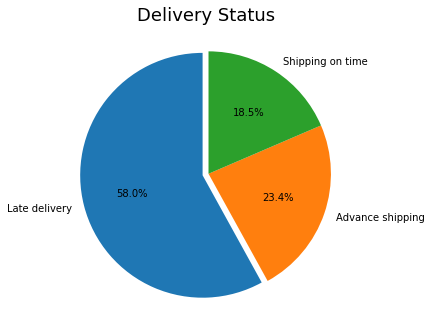

In [ ]:
plt.figure(figsize=(5,5))
temp = loss['Delivery Status'].value_counts()
plt.pie(temp.values, explode=[0.05, 0, 0], labels=temp.index, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")   
plt.title('Delivery Status',fontsize=18,pad=18) 
print('late delivery caused loss ratio: ',round(loss[loss['Delivery Status']=='Late delivery']['Benefit per order'].sum()/loss['Benefit per order'].sum(),4))

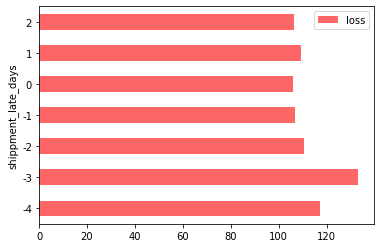

In [ ]:
abs(loss.groupby('shippment_late_days')['Benefit per order'].mean()).plot.barh(color='r',alpha=0.6,label='loss')
plt.legend()

Text(0.5, 0, '')

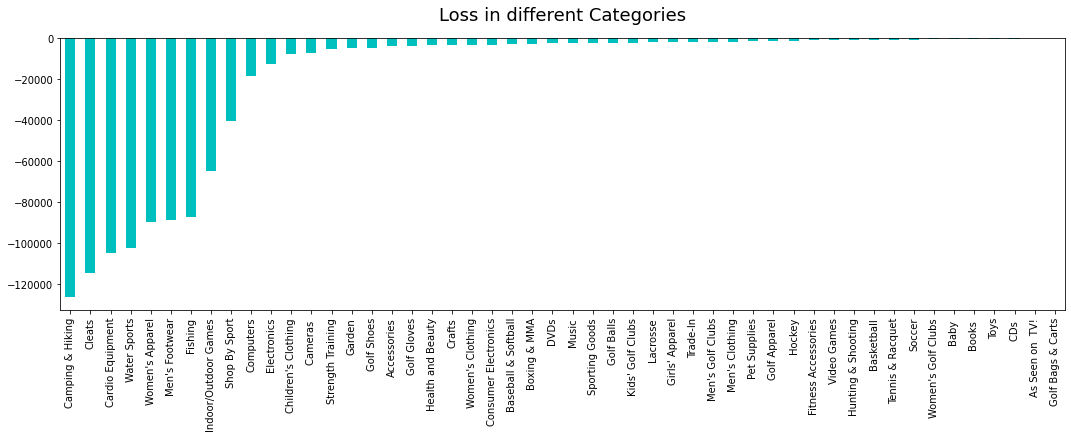

In [ ]:
ls = loss.groupby('Category Name')['Benefit per order'].sum().sort_values(ascending=True)
a = ls.plot.bar(figsize=(18,5),color='c')
plt.title('Loss in different Categories',fontsize=18,pad=18)
plt.xlabel('')

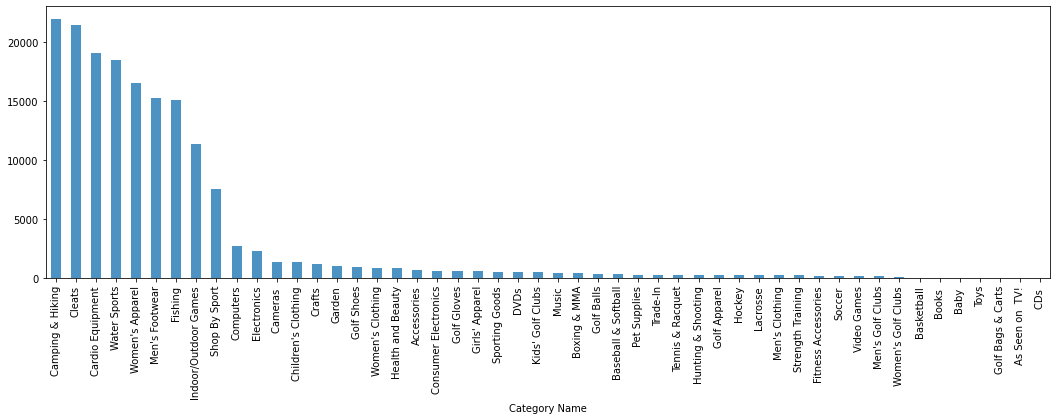

In [ ]:
loss.groupby('Category Name')['Order Item Discount'].sum().sort_values(ascending=False).plot.bar(figsize=(18,5),alpha=0.8)

Text(0.5, 0, '')

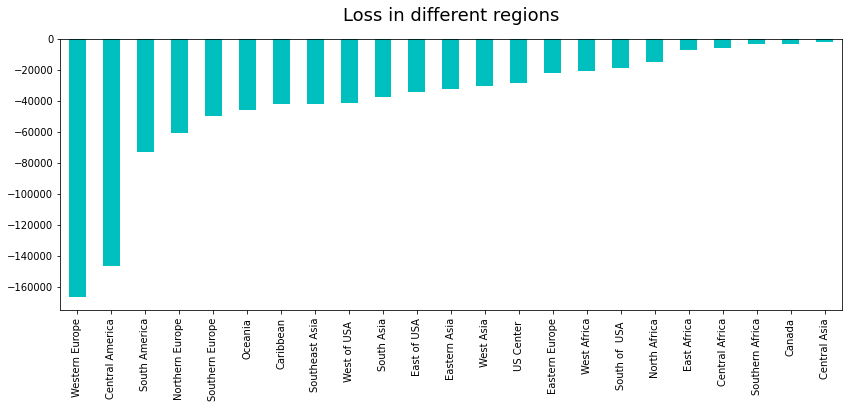

In [ ]:
ors = loss.groupby('Order Region')['Benefit per order'].sum().sort_values(ascending=True)
a = ors.plot.bar(figsize=(14,5),color='c')
plt.title('Loss in different regions',fontsize=18,pad=18)
plt.xlabel('')

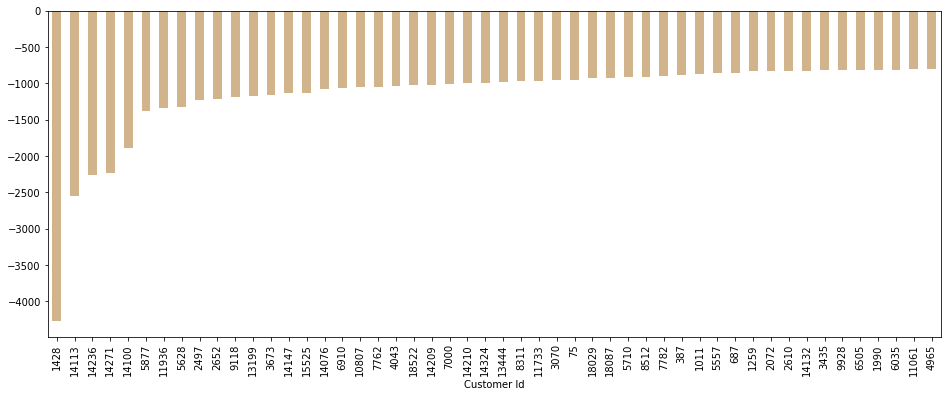

In [ ]:
highloss = loss[loss['Benefit per order']<-500]
highloss.groupby('Customer Id')['Benefit per order'].mean().sort_values(ascending=True).head(50).plot.bar(figsize=(16,6),color='tan')

# Fraud analysis

In [ ]:
fraud['Type'].value_counts()

TRANSFER    2388
Name: Type, dtype: int64

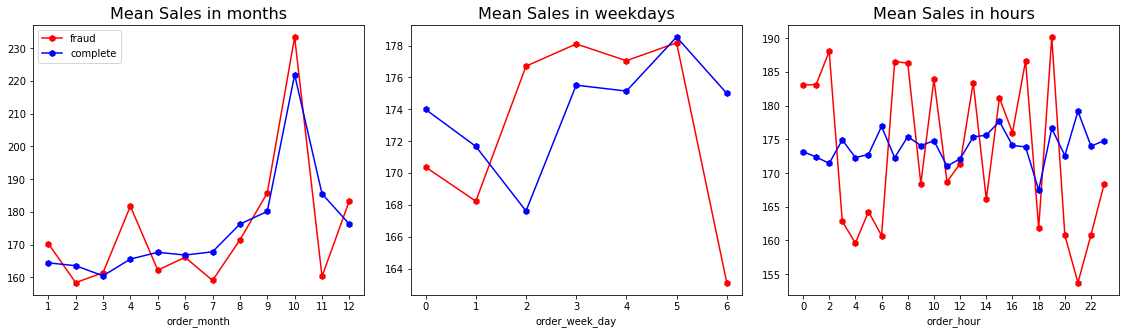

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(131)
salesByMonth = fraud.groupby('order_month')['Sales per customer'].mean()
salesByMonth.plot(color='r',marker='h',label='fraud')
comp.groupby('order_month')['Sales per customer'].mean().plot(color='b',marker='h',label='complete')
plt.xticks(np.arange(1,13,1))
plt.legend()
plt.title('Mean Sales in months',fontsize=16)

plt.subplot(132)
salesByWeekday = fraud.groupby('order_week_day')['Sales per customer'].mean()
salesByWeekday.plot(color='r',marker='h',label='fraud')
comp.groupby('order_week_day')['Sales per customer'].mean().plot(color='b',marker='h',label='complete')
plt.xticks(np.arange(0,7,1))
plt.title('Mean Sales in weekdays',fontsize=16)

plt.subplot(133)
salesByHour = fraud.groupby('order_hour')['Sales per customer'].mean()
salesByHour.plot(color='r',marker='h',label='fraud')
comp.groupby('order_hour')['Sales per customer'].mean().plot(color='b',marker='h',label='complete')
plt.xticks(np.arange(0,24,2))
plt.title('Mean Sales in hours',fontsize=16)
plt.tight_layout(pad=2.0)

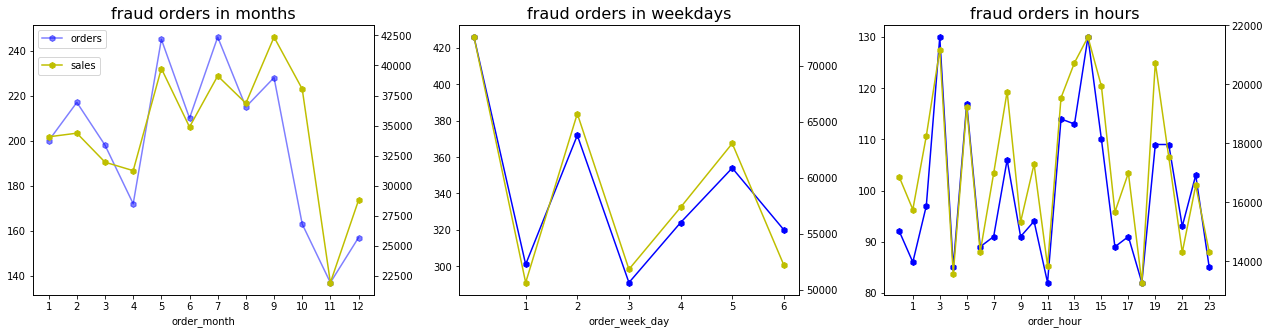

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(131)
a = fraud.groupby('order_month')['Sales per customer'].size().plot(color='b',marker='h',alpha=0.5,label='orders')
plt.xticks(np.arange(1,13,1))
plt.title('fraud orders in months',fontsize=16)
plt.legend(loc='upper left')
a2 = a.twinx()
a2.plot(fraud.groupby('order_month')['Sales per customer'].sum(),color='y',marker='h',label='sales')
plt.legend(bbox_to_anchor = (0.21,0.9))

plt.subplot(132)
b = fraud.groupby('order_week_day')['Sales per customer'].size().plot(color='b',marker='h',label='orders')
plt.xticks(np.arange(1,8,1))
plt.title('fraud orders in weekdays',fontsize=16)
b2 = b.twinx()
b2.plot(fraud.groupby('order_week_day')['Sales per customer'].sum(),color='y',marker='h',label='sales')

plt.subplot(133)
c = fraud.groupby('order_hour')['Sales per customer'].size().plot(color='b',marker='h',label='orders')
plt.xticks(np.arange(1,25,2))
plt.title('fraud orders in hours',fontsize=16)
c2 = c.twinx()
c2.plot(fraud.groupby('order_hour')['Sales per customer'].sum(),color='y',marker='h',label='sales')
plt.tight_layout(pad=2.0)

Text(0.5, 1.0, 'fraud sales in order regions')

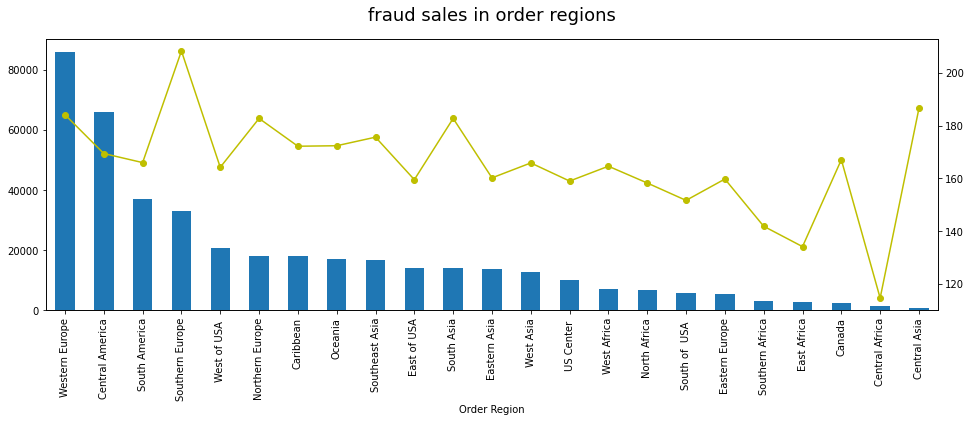

In [ ]:
t = fraud.groupby('Order Region')['Sales per customer'].sum().sort_values(ascending=False)
a = t.plot.bar(figsize=(16,5))
b = a.twinx()
b.plot(fraud.groupby('Order Region')['Sales per customer'].mean().reindex(t.index.values),marker='o',color='y')
plt.title('fraud sales in order regions',fontsize=18,pad=18)

Text(0.5, 1.0, 'Fraud sales in categories')

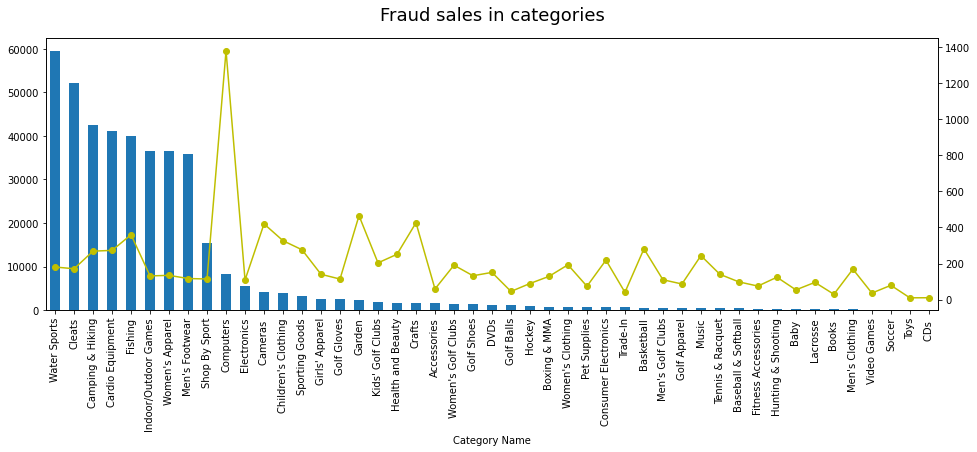

In [ ]:
t = fraud.groupby('Category Name')['Sales per customer'].sum().sort_values(ascending=False)
a = t.plot.bar(figsize=(16,5))
b = a.twinx()
b.plot(fraud.groupby('Category Name')['Sales per customer'].mean().reindex(t.index.values),marker='o',color='y')
plt.title('Fraud sales in categories',fontsize=18,pad=18)

In [ ]:
t = fraud.groupby('Category Name')['Sales per customer'].sum().sort_values(ascending=False)
a = t.plot.bar(figsize=(16,5))
b = a.twinx()
b.plot(fraud.groupby('Category Name')['Sales per customer'].mean().reindex(t.index.values),marker='o',color='y')

In [ ]:
fraud.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Product Status,shippment_late_days,isfraud,isloss,ship_year,ship_month,ship_week_day,ship_hour,order_year,order_month,order_week_day,order_hour,ship_after_order
count,2388.000000,2388.000000,2388.000000,2388.000000,2388.0,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.0,2388.000000,2388.0,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000
mean,3.435092,2.756700,20.784263,173.124725,0.0,32.283501,6898.037270,37320.658291,5.466918,30.658371,-85.516799,37130.107621,703.154941,19.839996,0.103516,92555.020519,129.789023,0.117249,2.163317,192.964493,0.0,-0.678392,1.0,0.193467,2016.012982,6.278476,3.019682,11.496650,2016.007119,6.246231,2.891122,11.496650,3.402848
std,1.652579,1.423609,92.542767,112.940914,0.0,15.515322,4048.375049,36937.388415,1.630304,9.739662,23.023514,21879.782753,336.671052,19.474898,0.070312,54273.711225,126.177966,0.457764,1.497142,123.297661,0.0,1.442517,0.0,0.395099,0.849998,3.300976,1.988875,6.778962,0.849574,3.293060,2.046966,6.838032,1.708607
min,0.000000,0.000000,-862.099976,8.660000,0.0,2.000000,16.000000,612.000000,2.000000,18.018362,-158.025986,69.000000,24.000000,0.000000,0.000000,168.000000,9.990000,-2.750000,1.000000,11.290000,0.0,-4.000000,1.0,0.000000,2015.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,6.467500,103.989998,0.0,18.000000,3631.000000,725.000000,4.000000,18.274560,-98.522713,17197.000000,403.000000,6.000000,0.040009,43006.750000,49.995000,0.070007,1.000000,119.980003,0.0,-1.000000,1.0,0.000000,2015.000000,3.000000,1.000000,5.750000,2015.000000,3.000000,1.000000,5.000000,2.000000
50%,3.000000,4.000000,31.405001,163.929993,0.0,29.000000,6585.000000,22204.000000,5.000000,33.825069,-78.763847,38066.000000,627.000000,14.820000,0.099976,95021.500000,59.990002,0.270020,1.000000,199.919998,0.0,-1.000000,1.0,0.000000,2016.000000,6.000000,3.000000,12.000000,2016.000000,6.000000,3.000000,12.000000,3.000000
75%,5.000000,4.000000,61.392500,220.000000,0.0,46.000000,9898.250000,78207.000000,7.000000,39.927249,-66.370598,57225.000000,1014.000000,28.792500,0.160034,143137.250000,199.990005,0.350098,3.000000,249.899994,0.0,0.000000,1.0,0.000000,2017.000000,9.000000,5.000000,17.000000,2017.000000,9.000000,5.000000,17.000000,5.000000
max,6.000000,4.000000,574.200012,1455.000000,0.0,76.000000,20737.000000,98632.000000,12.000000,47.843224,115.263077,77184.000000,1363.000000,255.000000,0.250000,180499.000000,1500.000000,0.500000,5.000000,1500.000000,0.0,2.000000,1.0,1.000000,2018.000000,12.000000,6.000000,23.000000,2018.000000,12.000000,6.000000,23.000000,6.000000


In [ ]:
fraud.describe(include='O')

,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Region,Order State,Order Status,Product Name,shipping date (DateOrders),Shipping Mode
count,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388
unique,1,1,47,323,2,1,280,483,1,3,38,1012,11,5,681,92,1121,23,367,1,99,1118,4
top,TRANSFER,Shipping canceled,Water Sports,Caguas,EE. UU.,XXXXXXXXX,Mary,Smith,XXXXXXXXX,Consumer,PR,9133 Cotton Robin Vale,Fan Shop,Europe,Managua,Estados Unidos,9/1/2017 1:05,Western Europe,California,SUSPECTED_FRAUD,Pelican Sunstream 100 Kayak,7/27/2016 15:08,Standard Class
freq,2388,2388,329,781,1585,2388,819,887,2388,1115,803,16,887,760,41,317,5,467,73,2388,329,6,1284


# Custmor segement

RFM model

In [ ]:
cs = pd.read_csv('/content/gdrive/MyDrive/supply_chain_data/SupplyChain.csv', encoding='unicode_escape')[['Order Customer Id','order date (DateOrders)','Order Id','Benefit per order','Order Item Discount']]
cs['order date (DateOrders)'] = pd.to_datetime(cs['order date (DateOrders)'])

In [ ]:
import datetime
now = datetime.datetime(2018,2,1)
customer_seg = cs.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (now - x.max()).days,
                            'Order Id': lambda x: len(x),
                            'Benefit per order': lambda x: round(x.sum(),2)
                            })
customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 'Order Id': 'F_Value', 'Benefit per order': 'M_Value'},inplace = True)

In [ ]:
customer_seg.head(3)

,R_Value,F_Value,M_Value
Order Customer Id,,,
1.0,792,1,159.69
2.0,136,9,340.44
3.0,229,7,-52.72


In [ ]:
quantiles = customer_seg.iloc[:,:3].quantile([0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

{'R_Value': {0.25: 88.0, 0.5: 181.0, 0.75: 344.0},
 'F_Value': {0.25: 1.0, 0.5: 5.0, 0.75: 11.0},
 'M_Value': {0.25: 5.26, 0.5: 101.19, 0.75: 303.7525}}

In [ ]:
def R_Score(a, b, c):
    if a <= c[b][0.25]:
        return 4
    elif a<= c[b][0.50]:
        return 3
    elif a<= c[b][0.75]:
        return 2
    else:
        return 1

def FM_Score(a, b ,c):
    if a <= c[b][0.25]:
        return 1
    elif a<= c[b][0.50]:
        return 2
    elif a<= c[b][0.75]:
        return 3
    else:
        return 4

In [ ]:
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1.0,792,1,159.69,1,1,3
2.0,136,9,340.44,3,3,4
3.0,229,7,-52.72,2,3,1
4.0,380,12,-354.35,1,4,1
5.0,457,6,280.60,1,3,3
...,...,...,...,...,...,...
20752.0,0,1,103.59,4,1,3
20754.0,0,1,-126.56,4,1,1
20755.0,0,1,91.25,4,1,2


In [ ]:
print("Rscore_mean: ",customer_seg['R_Score'].mean().round(2))
print("Fscore_mean: ",customer_seg['F_Score'].mean().round(2))
print("Mscore_mean: ",customer_seg['M_Score'].mean().round(2))

Rscore_mean:  2.5
Fscore_mean:  2.36
Mscore_mean:  2.5


In [ ]:
def RFM_User(df):
    if df['M_Score'] > 2.5 and df['F_Score'] > 2.4 and df['R_Score'] > 2.5:
        return 'champions'
    elif df['M_Score'] > 2.5 and df['F_Score'] <= 2.4 and df['R_Score'] > 2.5:
        return 'potential loyalist'
    elif df['M_Score'] > 2.5 and df['F_Score'] > 2.4 and df['R_Score'] <= 2.5:
        return 'loyal users'
    elif df['M_Score'] > 2.5 and df['F_Score'] <= 2.4 and df['R_Score'] <= 2.5:
        return 'promising'
    elif df['M_Score'] <= 2.5 and df['F_Score'] > 2.4 and df['R_Score'] > 2.5:
        return 'users needing attention'
    elif df['M_Score'] <= 2.5 and df['F_Score'] <= 2.4 and df['R_Score'] > 2.5:
        return 'cannot lose them'
    elif df['M_Score'] <= 2.5 and df['F_Score'] > 2.4 and df['R_Score'] <= 2.5:
        return 'at risk'
    elif df['M_Score'] <= 2.5 and df['F_Score'] <= 2.4 and df['R_Score'] <= 2.5:
        return 'hibernating'

In [ ]:
customer_seg['Customer_Segmenation'] = customer_seg.apply(RFM_User, axis=1)
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmenation
Order Customer Id,,,,,,,
1.0,792,1,159.69,1,1,3,promising
2.0,136,9,340.44,3,3,4,champions
3.0,229,7,-52.72,2,3,1,at risk
4.0,380,12,-354.35,1,4,1,at risk
5.0,457,6,280.60,1,3,3,loyal users
...,...,...,...,...,...,...,...
20752.0,0,1,103.59,4,1,3,potential loyalist
20754.0,0,1,-126.56,4,1,1,cannot lose them
20755.0,0,1,91.25,4,1,2,cannot lose them


In [ ]:
customer_seg['Customer_Segmenation'].value_counts()

cannot lose them           5227
loyal users                4668
at risk                    1933
champions                  1813
potential loyalist         1650
hibernating                1500
promising                  1188
users needing attention     661
Name: Customer_Segmenation, dtype: int64

k_means segement

In [ ]:
customer_seg2 = (customer_seg.iloc[:,:3]-customer_seg.iloc[:,:3].mean())/customer_seg.iloc[:,:3].std()
customer_seg2

,R_Value,F_Value,M_Value
Order Customer Id,,,
1.0,2.494703,-0.902327,0.040018
2.0,-0.508921,0.299593,0.598994
3.0,-0.083103,-0.000887,-0.616868
4.0,0.608280,0.750313,-1.549669
5.0,0.960840,-0.151127,0.413936
...,...,...,...
20752.0,-1.131624,-0.902327,-0.133473
20754.0,-1.131624,-0.902327,-0.845220
20755.0,-1.131624,-0.902327,-0.171635


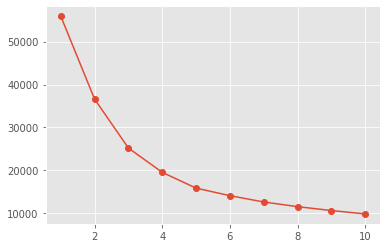

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
 
wgss=[]   
for i in range(10):
    cluster = KMeans(n_clusters=i+1, random_state=0).fit(customer_seg2)
    wgss.append(cluster.inertia_)  

plt.plot([i+1 for i in range(10)],wgss,marker='o')

In [ ]:
from sklearn.cluster import KMeans
model=KMeans(n_clusters=5) 
model.fit(customer_seg2) 
r1=pd.Series(model.labels_).value_counts() 
r2=pd.DataFrame(model.cluster_centers_) 
r=pd.concat([r2,r1],axis=1)
r.columns=list(customer_seg2.columns)+['counts'] 
r

,R_Value,F_Value,M_Value,counts
0,0.146589,0.358623,0.318352,4985
1,0.106969,0.747573,-1.848774,1476
2,-0.768728,-0.853551,-0.308753,7376
3,-0.002653,1.696522,1.523283,2426
4,2.013389,-0.299154,-0.111607,2377


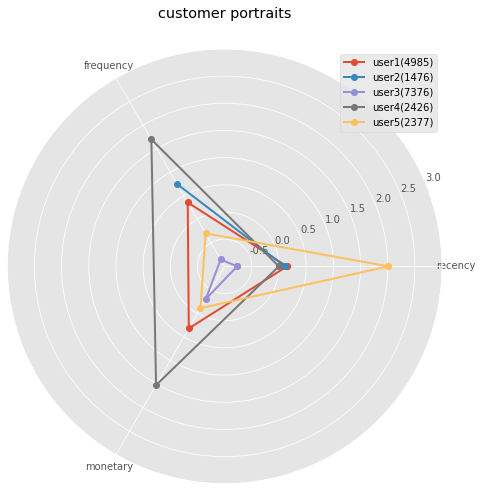

In [ ]:
plt.style.use('ggplot') 
plt.rcParams['axes.unicode_minus']=False 
labels=np.array(["recency","frequency","monetary"])
N=r2.shape[1]
angles=np.linspace(0,2*np.pi,N,endpoint=False) 
data=pd.concat([r2,r2.iloc[:,0]],axis=1) 
angles=np.concatenate((angles,[angles[0]]))  
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,polar=True)
for i in range(r2.shape[0]):
    j=i+1
    ax.plot(angles,
        data.iloc[i,:],
        'o-',
        linewidth=2, 
        label="user%s(%s)"%(j,r['counts'][i])
        )
ax.set_thetagrids(angles*180/np.pi,labels)  
ax.set_title('customer portraits',va='bottom')
ax.set_rlim(-1,3) 
ax.grid(True)
plt.legend()
plt.show()

In [ ]:
l = pd.DataFrame(model.labels_.reshape(-1, 1))
l.rename(columns={"0": "label"})
l.index = customer_seg2.index
customer_seg2 = pd.concat([customer_seg2,l],axis=1)

In [ ]:
customer_seg2

,R_Value,F_Value,M_Value,0
Order Customer Id,,,,
1.0,2.494703,-0.902327,0.040018,4
2.0,-0.508921,0.299593,0.598994,0
3.0,-0.083103,-0.000887,-0.616868,0
4.0,0.608280,0.750313,-1.549669,1
5.0,0.960840,-0.151127,0.413936,0
...,...,...,...,...
20752.0,-1.131624,-0.902327,-0.133473,2
20754.0,-1.131624,-0.902327,-0.845220,2
20755.0,-1.131624,-0.902327,-0.171635,2


In [ ]:
import pickle
with open('/content/gdrive/MyDrive/supply_chain_data/data.pkl', 'wb') as file:
    pickle.dump(df, file)